## Imports

In [160]:
import itertools
import math
import shap

from collections import Counter

from eli5 import show_weights

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.model_selection import cross_validate, cross_val_score

from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline
from prettytable import PrettyTable
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier, XGBRegressor

import lightgbm as lgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt
import seaborn as sns

## Initial Observations

In [2]:
nike = pd.read_csv("data/nike.csv")

print("Basic information about our Nike.com dataset:\n")
print(nike.info())
print(
    "\n\nA little more summary info about our data "
    "(there\nare only a few columns in our data, making "
    "this\neasy to inspect):\n\n",
    nike.describe(),
)
print("\n\nAnd, the first few rows of our data:")
display(nike.head())

Basic information about our Nike.com dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1368 entries, 0 to 1367
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1368 non-null   int64  
 1   label          409 non-null    object 
 2   title          1368 non-null   object 
 3   subtitle       1367 non-null   object 
 4   num_colors     1368 non-null   object 
 5   price          1366 non-null   object 
 6   reduced_price  579 non-null    object 
 7   url            1368 non-null   object 
 8   description    1340 non-null   object 
 9   colors         840 non-null    object 
 10  n_reviews      1271 non-null   float64
 11  avg_stars      1271 non-null   float64
dtypes: float64(2), int64(1), object(9)
memory usage: 128.4+ KB
None


A little more summary info about our data (there
are only a few columns in our data, making this
easy to inspect):

         Unnamed: 0    n_reviews    avg_sta

,Unnamed: 0,label,title,subtitle,num_colors,price,reduced_price,url,description,colors,n_reviews,avg_stars
0,0,Best Seller,Air Jordan 1 Mid,Shoes,2 Colors,$125,NaN,https://www.nike.com/t/air-jordan-1-mid-shoes-...,"Inspired by the original AJ1, the Air Jordan 1...",Black/White/Fire Red; Black/Black/Black,2161.0,4.9
1,1,Best Seller,Nike Blazer Mid '77 Vintage,Women's Shoes,3 Colors,$105,NaN,https://www.nike.com/t/blazer-mid-77-vintage-w...,Styled for the ‘70s. Loved in the ‘80s. Classi...,White/White/Peach/White; White/Sail/Peach/Blac...,519.0,4.8
2,2,Coming Soon,Nike Dunk Low Retro,Men's Shoes,1 Color,$110,NaN,https://www.nike.com/t/dunk-low-retro-mens-sho...,Created for the hardwood but taken to the stre...,NaN,NaN,NaN
3,3,Best Seller,Nike Air Force 1 '07,Men's Shoes,2 Colors,$110,NaN,https://www.nike.com/t/air-force-1-07-mens-sho...,The radiance lives on in the Nike Air Force 1 ...,Black/White; White/Black; Design your own Nike...,128.0,4.9
4,4,Best Seller,Air Jordan 12 Retro,Men's Shoes,1 Color,$200,NaN,https://www.nike.com/t/air-jordan-12-retro-men...,No need to call for a ride—MJ's game-winning l...,NaN,333.0,4.9


## Plot Numeric Variables

In [3]:
nike['price'] = nike['price'].str.replace('$','').astype(np.float64)
nike['num_colors'] = nike['num_colors'].str.replace(' Colors','').str.replace(' Color','').astype(np.float64)

/tmp/ipykernel_2639/405425822.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  nike['price'] = nike['price'].str.replace('$','').astype(np.float64)


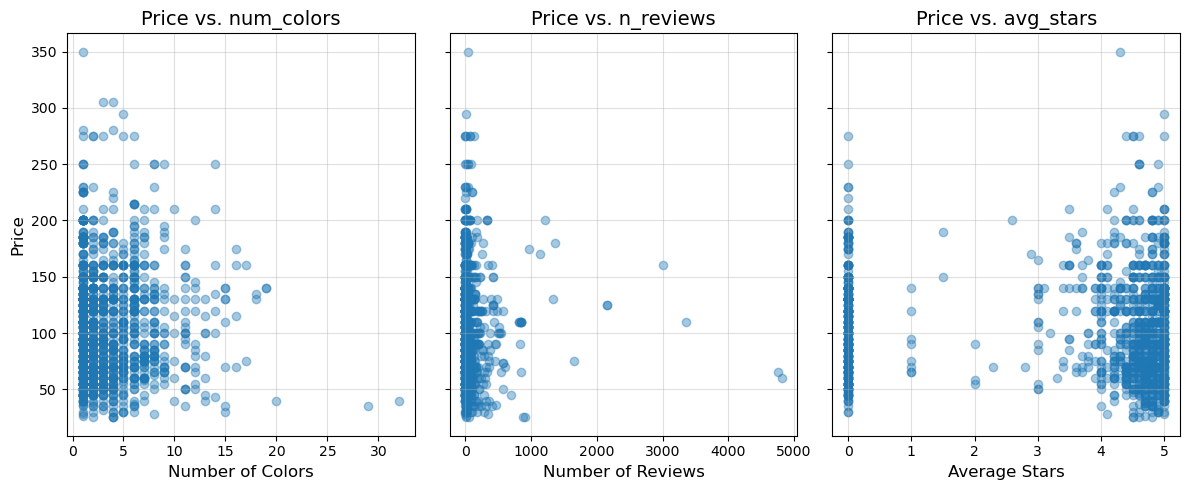

In [4]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 5))

fontsize = 14

cols = ["num_colors", "n_reviews", "avg_stars"] 
title_vs_text = ["num_colors", "n_reviews", "avg_stars"]
xlabels = ["Number of Colors", "Number of Reviews", "Average Stars"]

for i, (ax, col, title_vs, xlabel) in enumerate(
    zip(axes, cols, title_vs_text, xlabels)
):

    ax.scatter(nike[col], nike["price"], alpha=0.4)
    ax.set_title(
        f"Price vs. {title_vs}",
        fontsize=fontsize,
    )
    ax.set_xlabel(xlabel, fontsize=fontsize-2)
    ax.set_ylabel(
        "Price" if i==0 else None, 
        fontsize=fontsize-2
    )
    ax.grid(":", alpha=0.4)

plt.tight_layout()

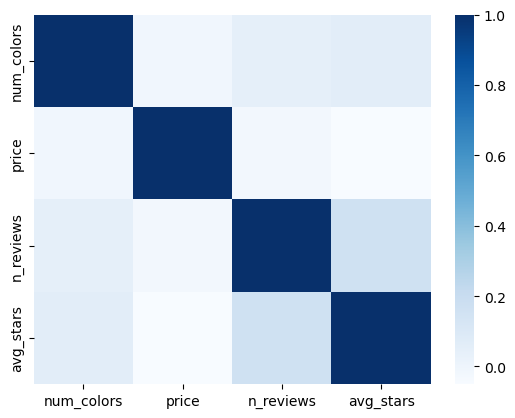

In [5]:
cor = nike.drop('Unnamed: 0', axis=1).corr()

sns.heatmap(cor, cmap='Blues')
plt.show()

## Plot Categorical Variables

In [6]:
list_label = nike['label'].unique().tolist()
len_label = len(list_label)
print(f'There are {len_label} unique labels which are {list_label}')

There are 10 unique labels which are ['Best Seller', 'Coming Soon', nan, 'Sustainable Materials', 'Member Access', 'Customize', 'Just In', 'Launching in SNKRS', 'Available in SNKRS', 'Sold Out']


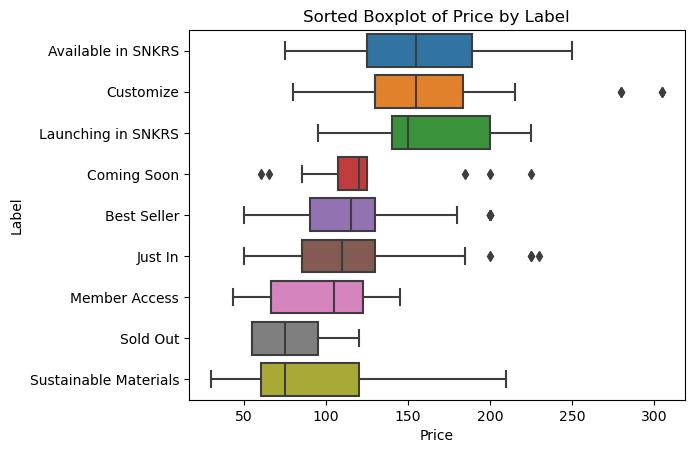

In [7]:
labels_sorted = nike.groupby('label').price.median().sort_values(ascending=False)

# order box plot by median
sns.boxplot(data=nike, y='label', x='price', order=labels_sorted.index)
plt.xlabel('Price')
plt.ylabel('Label')
plt.title('Sorted Boxplot of Price by Label')
plt.show()

In [8]:
top_subtitles = nike.subtitle.value_counts().head()
top_subtitles

Men's Shoes           224
Women's Shoes         129
Big Kids' Shoes       117
Little Kids' Shoes     99
Baby/Toddler Shoes     87
Name: subtitle, dtype: int64

In [9]:
nike_top_subtitles = nike.loc[nike.subtitle.isin(top_subtitles.index.tolist())]

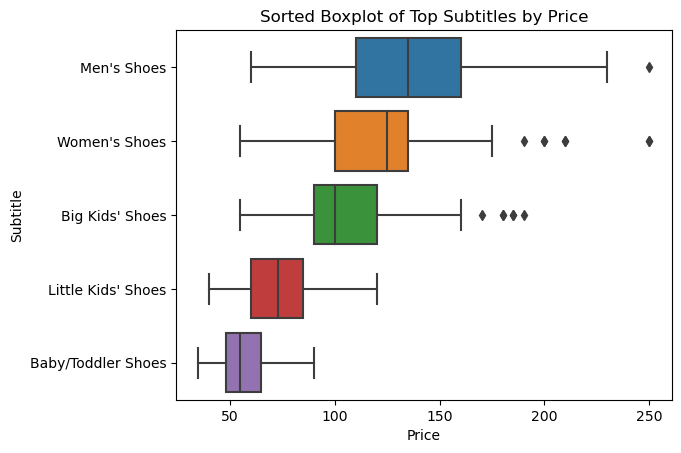

In [10]:
top_subtitles_sorted = nike_top_subtitles.groupby('subtitle').price.median().sort_values(ascending=False)

# order box plot by median
sns.boxplot(data=nike_top_subtitles, y='subtitle', x='price', order=top_subtitles_sorted.index)
plt.xlabel('Price')
plt.ylabel('Subtitle')
plt.title('Sorted Boxplot of Top Subtitles by Price')
plt.show()

* This makes sense, as subtitle category could be a proxy for average shoe size

## Numeric Stats

In [11]:
mean_price = nike["price"].mean() 
mean_noc = nike["num_colors"].mean()
std_price = nike["price"].std() 
std_noc = nike["num_colors"].std()
print(
    "\n"
    f"The mean price is {mean_price:.4f} \n"
    f"The mean number of colors is {mean_noc:.4f} \n"
    f"The Standard Deviation of price is {std_price:.4f}\n"
    f"The Standard Deviation of number of colors is {std_noc:.4f}"
)


The mean price is 108.3433 
The mean number of colors is 3.5322 
The Standard Deviation of price is 47.8272
The Standard Deviation of number of colors is 3.3771


In [12]:
price_min = nike["price"].min()
price_max = nike["price"].max() 
price_range = price_max - price_min 

print(
    f"The range of price for which shoes in our dataset "
    f"is {price_range:,.2f} dolloars. \n\n"
    f"The maximum number of price is {price_max:,.2f}, "
    f"and the minimum is {price_min:,.2f}."
)

The range of price for which shoes in our dataset is 325.00 dolloars. 

The maximum number of price is 350.00, and the minimum is 25.00.


/home/devillish_red/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


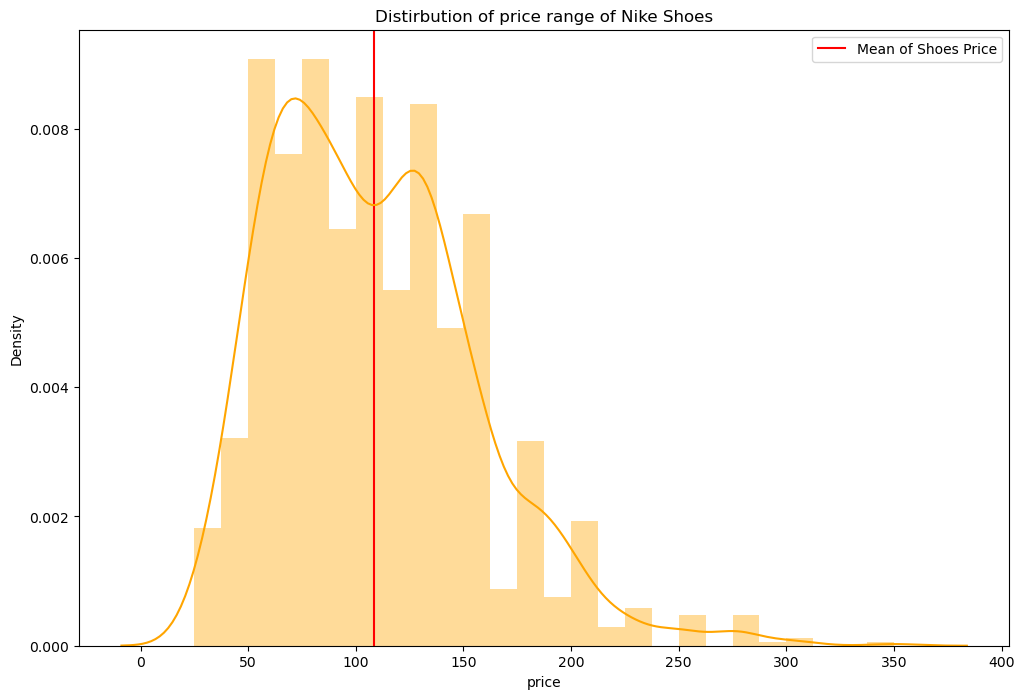

In [13]:
plt.figure(figsize=(12,8))
#ploting the mean
plt.axvline(mean_price, 0, 1, color = 'red', label='Mean of Shoes Price')
sns.distplot(nike['price'], color='orange')
plt.title("Distirbution of price range of Nike Shoes")
plt.legend()
plt.show()

## Missing Data

In [14]:
n_rows_with_missingness = np.int64(sum([True for idx,row in nike.iterrows() if any(row.isnull())]))
n_cols_with_missingness = np.int64(sum(nike.apply(lambda x: sum(x.isnull().values), axis = 0)>0))

columns = nike.columns.values
col_num = []
for i in columns:
    col_num.append(nike[i].isnull().sum())
col_missingness = pd.Series(col_num, index=nike.columns)
col_missingness

Unnamed: 0         0
label            959
title              0
subtitle           1
num_colors         0
price              2
reduced_price    789
url                0
description       28
colors           528
n_reviews         97
avg_stars         97
dtype: int64

In [15]:
# Replaced Missing Values with Median For Now
median_price = nike['price'].median()
nike['price'].fillna(median_price, inplace=True)

## NLP: Text Preprocessing

## Process Column `description` from Raw Text to Bag-of-Words

In [16]:
df_desc = nike.loc[:, ['description', 'price']].copy()  # subset
df_desc.dropna(inplace=True)  # drop na
df_desc.head()

,description,price
0,"Inspired by the original AJ1, the Air Jordan 1...",125.0
1,Styled for the ‘70s. Loved in the ‘80s. Classi...,105.0
2,Created for the hardwood but taken to the stre...,110.0
3,The radiance lives on in the Nike Air Force 1 ...,110.0
4,No need to call for a ride—MJ's game-winning l...,200.0


In [82]:
df_desc.shape

(1340, 2)

In [18]:
# remove punctuation
df_desc['description'] = df_desc['description'].str.replace(r'([^\w\s]|_)+', '', regex=True)

In [19]:
# tokenization
df_desc['description'] = df_desc['description'].str.split()

In [20]:
# load list of stop words
stopwords = pd.read_csv('data/stopwords_nopunc.csv').stopwords.values

In [21]:
# remove stop words from data
df_desc['description'] = df_desc['description'].apply(lambda x: [str(w) for w in x if w not in stopwords])

In [22]:
# create a dictionary (or Series) with the counts of each unique vocab word
vocab_counts = df_desc['description'].explode().value_counts()

In [23]:
# define vocabulary
# list of unique words occuring at least 5 times in the dataset
min_count = 5
vocab = [k for k,v in vocab_counts.items() if v >= 5]

In [24]:
print(f"We have {len(vocab):,} unique words in our reduced, corpus vocabulary.")

We have 1,425 unique words in our reduced, corpus vocabulary.


In [25]:
# remove low-occurance words
df_desc['description'] = df_desc['description'].apply(lambda x: [w for w in x if w in vocab])

In [26]:
# bag of words representation
# list of Counters
# each Counter containing word counts for each row in the DataFrame
counts = df_desc['description'].apply(Counter).to_list()

In [27]:
# Create bag-of-words df from list of dictionaries
bow_df = pd.DataFrame(counts).fillna(0).astype(int)

## Make `price` Categorical with Binning

In [28]:
df_desc.reset_index(drop=True, inplace=True)

In [29]:
# combine what is effectively our X and y into a single DataFrame
df_processed = pd.concat([bow_df, df_desc['price']], axis=1)
df_processed.head()

,inspired,original,aj1,air,jordan,1,mid,offers,fans,follow,...,use,unleash,grass,artisan,coating,slides,decades,eyestays,pink,price
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,125.0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,105.0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,110.0
3,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,110.0
4,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,200.0


In [30]:
# split price into bins to make it categorical
df_processed['price'] = pd.cut(df_processed['price'], bins=5)
df_processed['price']

0        (90.0, 155.0]
1        (90.0, 155.0]
2        (90.0, 155.0]
3        (90.0, 155.0]
4       (155.0, 220.0]
             ...      
1335    (24.675, 90.0]
1336    (24.675, 90.0]
1337     (90.0, 155.0]
1338     (90.0, 155.0]
1339    (24.675, 90.0]
Name: price, Length: 1340, dtype: category
Categories (5, interval[float64, right]): [(24.675, 90.0] < (90.0, 155.0] < (155.0, 220.0] < (220.0, 285.0] < (285.0, 350.0]]

In [31]:
# df_processed['price'] = df_processed['price'].astype('string')

## Naive Bayes Model of `price ~ bag_of_words(description)`

In [32]:
df_processed1 = df_processed.copy()
df_processed1['price'] = df_processed1['price'].astype('string')

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_processed1.drop('price', axis=1),
                                                    df_processed1['price'], test_size=0.2, random_state=109)

In [34]:
mnb = MultinomialNB().fit(X_train, y_train)

In [35]:
mnb.score(X_test, y_test)

0.7164179104477612

***Feature importance for each class:***

In [36]:
# 5 brackets
y_train.value_counts(sort=False)

(24.675, 90.0]    464
(90.0, 155.0]     455
(155.0, 220.0]    133
(220.0, 285.0]     16
(285.0, 350.0]      4
Name: price, dtype: Int64

In [37]:
# get most predictive words for each class (bracket 1 and bracket 3)
feat_imp_list = []

for i in range(len(mnb.classes_)):
    class_prob_sorted = mnb.feature_log_prob_[i, :].argsort()[::-1]
    top_pred_words = np.take(bow_df.columns, class_prob_sorted[:])
    feat_imp_list.append(top_pred_words)

The top 10 most predictive words for each price bracket:

In [38]:
# prettify list to df
feat_imp_df = pd.DataFrame(np.array(feat_imp_list).T, columns=mnb.classes_)
feat_imp_df = feat_imp_df.loc[:, y_train.value_counts(sort=False).index]  # reorder columns
feat_imp_df.head(10)

,"(24.675, 90.0]","(90.0, 155.0]","(155.0, 220.0]","(220.0, 285.0]","(285.0, 350.0]"
0,nike,air,air,air,air
1,design,nike,nike,nike,cleat
2,air,design,design,features,nike
3,little,comfort,max,phantom,zoom
4,comfort,cushioning,cushioning,design,like
5,foam,classic,feel,elite,soccer
6,classic,look,comfort,zoom,made
7,cushioning,upper,style,next,control
8,durable,feel,upper,provides,nods
9,made,max,look,control,world


## Baseline Model - OLS

In [39]:
# Initialize a list to store the MSE values and R2 scores
mse_list = []
r2_list = []
# List of all predictor combinations to fit the curve
cols = [['num_colors'],['n_reviews'],['avg_stars'],['num_colors','n_reviews'],['avg_stars','n_reviews'],['num_colors','avg_stars'],['num_colors','n_reviews','avg_stars']]
nike['num_colors'].fillna(nike['num_colors'].median(), inplace=True)
nike['n_reviews'].fillna(nike['n_reviews'].median(), inplace=True)
nike['avg_stars'].fillna(nike['avg_stars'].median(), inplace=True)



In [40]:
# Loop over all the predictor combinations 
for i in cols:
    # Replaced Missing Values with Median For Now
    
    print(i)
    # Set each of the predictors from the previous list as x
    x = nike[i]
    # Set the "Sales" column as the reponse variable
    y = nike['price']
   
    # Split the data into train-test sets with 80% training data and 20% testing data. 
    # Set random_state as 0
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.8,random_state=0)

    # Initialize a Linear Regression model
    lreg = LinearRegression()

    # Fit the linear model on the train data
    lreg.fit(x_train,y_train)
    
    # Predict the response variable for the test set using the trained model
    y_pred= lreg.predict(x_test)
    
    # Compute the MSE for the test data
    MSE = mean_squared_error(y_pred,y_test)
    r2 = r2_score(y_test, y_pred)
    
    # Append the computed MSE to the list
    mse_list.append(MSE)
    r2_list.append(r2)

['num_colors']
['n_reviews']
['avg_stars']
['num_colors', 'n_reviews']
['avg_stars', 'n_reviews']
['num_colors', 'avg_stars']
['num_colors', 'n_reviews', 'avg_stars']


In [41]:
# Helper code to display the MSE for each predictor combination
t = PrettyTable(['Predictors', 'MSE'])
p = PrettyTable(['Predictors', 'R2 score'])

for i in range(len(mse_list)):
    t.add_row([cols[i],round(mse_list[i], 2)])
    p.add_row([cols[i],round(r2_list[i], 2)])
    

print(t)
print(p)

+------------------------------------------+---------+
|                Predictors                |   MSE   |
+------------------------------------------+---------+
|              ['num_colors']              | 1974.42 |
|              ['n_reviews']               | 1967.54 |
|              ['avg_stars']               | 1976.13 |
|       ['num_colors', 'n_reviews']        | 1968.04 |
|        ['avg_stars', 'n_reviews']        | 1970.56 |
|       ['num_colors', 'avg_stars']        | 1976.64 |
| ['num_colors', 'n_reviews', 'avg_stars'] | 1971.13 |
+------------------------------------------+---------+
+------------------------------------------+----------+
|                Predictors                | R2 score |
+------------------------------------------+----------+
|              ['num_colors']              |  -0.01   |
|              ['n_reviews']               |   -0.0   |
|              ['avg_stars']               |  -0.01   |
|       ['num_colors', 'n_reviews']        |   -0.0   |
|  

## Prep Data for Advanced Modeling

### Non text features

In [42]:
# drop NA based on col description
df = nike.dropna(subset=['description']).copy()
df.head(1)

,Unnamed: 0,label,title,subtitle,num_colors,price,reduced_price,url,description,colors,n_reviews,avg_stars
0,0,Best Seller,Air Jordan 1 Mid,Shoes,2.0,125.0,NaN,https://www.nike.com/t/air-jordan-1-mid-shoes-...,"Inspired by the original AJ1, the Air Jordan 1...",Black/White/Fire Red; Black/Black/Black,2161.0,4.9


In [43]:
# subtitle categorical feature - men/women/kids - make that a gender feature
df.subtitle.value_counts()

Men's Shoes                               212
Women's Shoes                             121
Big Kids' Shoes                           117
Little Kids' Shoes                         98
Baby/Toddler Shoes                         86
                                         ... 
Men’s Training Shoes                        1
Men's Duckboot                              1
Women's Easy On/Off Road Running Shoes      1
Women's Slip                                1
Men's Football Cleat                        1
Name: subtitle, Length: 201, dtype: int64

In [44]:
# lower
df['gender'] = df.subtitle.str.lower()

In [45]:
# give NA a category
df['gender'].fillna('other', inplace=True)

In [46]:
# women
df['gender'].replace(regex='.*women.*', value='1', inplace=True)

In [47]:
# men
df['gender'].replace(regex='.*men.*', value='men', inplace=True)

In [48]:
# recover women
df['gender'].replace(regex='1', value='women', inplace=True)

In [49]:
# big kids
df['gender'].replace(regex='^big kids.*', value='big_kids', inplace=True)

In [50]:
# little kids
df['gender'].replace(regex='^little kids.*', value='little_kids', inplace=True)

In [51]:
# baby
df['gender'].replace(regex='^baby.*', value='baby', inplace=True)

In [52]:
# clean up kids
df['gender'].replace(regex='.* kid.*', value='big_kids', inplace=True)
df['gender'].replace(regex='.*crib.*', value='baby', inplace=True)

In [53]:
# other
df.loc[df.gender.str.match('^(?!.*(men|women|big_kids|little_kids|baby)).*$'), 'gender'] = 'other'

In [54]:
# final categories
df.gender.value_counts()

men            411
women          258
other          221
big_kids       216
little_kids    122
baby           112
Name: gender, dtype: int64

### Other non text features

In [55]:
# subset
df_sub = df.loc[:, ['num_colors', 'n_reviews', 'avg_stars', 'gender']].copy()
df_sub.head(3)

,num_colors,n_reviews,avg_stars,gender
0,2.0,2161.0,4.9,other
1,3.0,519.0,4.8,women
2,1.0,7.0,4.6,men


In [56]:
# dummy
df_sub = pd.get_dummies(df_sub)
df_sub.head(3)

,num_colors,n_reviews,avg_stars,gender_baby,gender_big_kids,gender_little_kids,gender_men,gender_other,gender_women
0,2.0,2161.0,4.9,0,0,0,0,1,0
1,3.0,519.0,4.8,0,0,0,0,0,1
2,1.0,7.0,4.6,0,0,0,1,0,0


In [57]:
# prefix all non-text features - to distinguish from BOW words
df_sub.columns = ['feature_' + col for col in df_sub.columns]
df_sub.head(3)

,feature_num_colors,feature_n_reviews,feature_avg_stars,feature_gender_baby,feature_gender_big_kids,feature_gender_little_kids,feature_gender_men,feature_gender_other,feature_gender_women
0,2.0,2161.0,4.9,0,0,0,0,1,0
1,3.0,519.0,4.8,0,0,0,0,0,1
2,1.0,7.0,4.6,0,0,0,1,0,0


### Concatenate with BOW

In [58]:
df_sub.reset_index(drop=True, inplace=True)

In [59]:
df_model = pd.concat([df_processed[['price']], df_sub, df_processed.drop('price', axis=1)], axis=1)

In [60]:
df_model.rename({'price': 'target_price'}, axis=1, inplace=True)

In [61]:
df_model.head()

,target_price,feature_num_colors,feature_n_reviews,feature_avg_stars,feature_gender_baby,feature_gender_big_kids,feature_gender_little_kids,feature_gender_men,feature_gender_other,feature_gender_women,...,optimal,use,unleash,grass,artisan,coating,slides,decades,eyestays,pink
0,"(90.0, 155.0]",2.0,2161.0,4.9,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,"(90.0, 155.0]",3.0,519.0,4.8,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,"(90.0, 155.0]",1.0,7.0,4.6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"(90.0, 155.0]",2.0,128.0,4.9,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"(155.0, 220.0]",1.0,333.0,4.9,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### convert `target_price` into integer

In [62]:
# the original labels
df_model['target_price'].value_counts()

(24.675, 90.0]    594
(90.0, 155.0]     556
(155.0, 220.0]    166
(220.0, 285.0]     20
(285.0, 350.0]      4
Name: target_price, dtype: int64

In [63]:
# label to int
df_model['target_price'] = df_model['target_price'].astype('category').cat.codes

In [64]:
df_model.head()

,target_price,feature_num_colors,feature_n_reviews,feature_avg_stars,feature_gender_baby,feature_gender_big_kids,feature_gender_little_kids,feature_gender_men,feature_gender_other,feature_gender_women,...,optimal,use,unleash,grass,artisan,coating,slides,decades,eyestays,pink
0,1,2.0,2161.0,4.9,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,3.0,519.0,4.8,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1.0,7.0,4.6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2.0,128.0,4.9,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1.0,333.0,4.9,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Note the structure:

- target: `target_price`
- non-text features: `feature_xxx` - 3 numeric, 1 categorical (dummified gender)
- text features from description: put at the end of the df

## XGBoost/LGBM Classification

In [65]:
df_model.to_csv('data/nike_model.csv', index=False)

In [66]:
est_df = df_model.loc[:,~df_model.columns.duplicated()]
X = est_df.drop('target_price', axis=1)
Y = est_df.iloc[:, 0].values

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
print(model)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)
Accuracy: 77.88%


In [67]:
features = df_model.columns[1:1435]
importance = model.feature_importances_
len(importance)


1434

Text(0.5, 0, 'Xgboost Feature Importance: Top 20 Most Important Features')

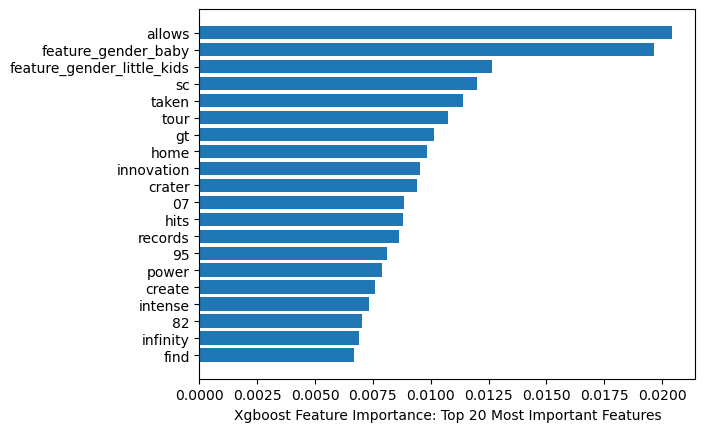

In [68]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(features[sorted_idx][-20:],importance[sorted_idx][-20:])

plt.xlabel("Xgboost Feature Importance: Top 20 Most Important Features")

In [69]:
# TAKES VERY LONG

# perm_importance = permutation_importance(model,X_test,y_test)
# sorted_idx_perm = perm_importance.importances_mean.argsort()
# plt.barh(features[sorted_idx_perm][-20:],perm_importance[sorted_idx_perm][-20:])
# plt.xlabel("Xgboost Permutation Feature Importance: Top 20 Most Important Features")

In [ ]:
params = {'boosting':'gbdt','objective': 'multiclass','num_leaves':10,'num_class':1435}
lgb_train = lgb.Dataset(X_train,y_train)
lgb_eval = lgb.Dataset(X_test,y_test,reference=lgb_train)

model = lgb.train(params,train_set = lgb_train,valid_sets=lgb_eval,early_stopping_rounds=30)

In [71]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred,axis=1)

cr = classification_report(y_test,y_pred)
cm = confusion_matrix(y_test,y_pred)

print(cr)
pd.crosstab(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.87      0.80      0.83       226
           1       0.63      0.81      0.71       159
           2       0.58      0.34      0.43        53
           3       0.50      0.25      0.33         4
           4       0.00      0.00      0.00         1

    accuracy                           0.74       443
   macro avg       0.52      0.44      0.46       443
weighted avg       0.75      0.74      0.73       443



/home/devillish_red/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/devillish_red/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/devillish_red/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


col_0,0,1,2,3
row_0,,,,
0,181,42,3,0
1,21,128,10,0
2,5,30,18,0
3,1,2,0,1
4,0,0,0,1


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

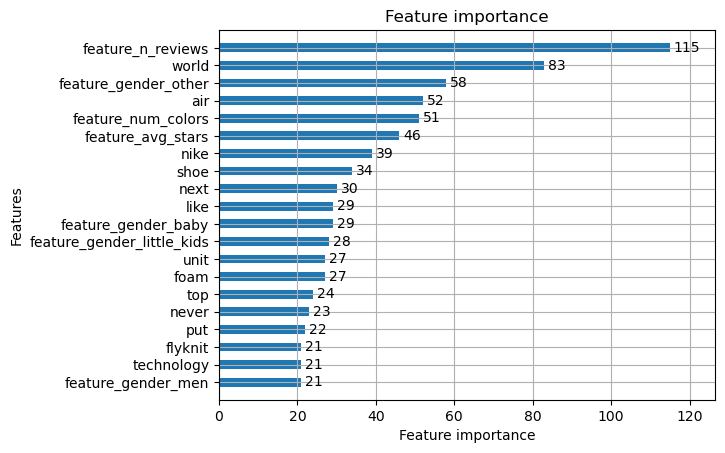

In [72]:
lgb.plot_importance(model,height=.5,max_num_features=20 )

## XGBoost Regression Trees

In [83]:
df_model_reg = df_model.copy()

In [85]:
df_model_reg['target_price'] = df_desc['price']

In [88]:
df_model_reg = df_model_reg.rename(columns={'target_price':'price'})

In [89]:
df_model_reg.head()

,price,feature_num_colors,feature_n_reviews,feature_avg_stars,feature_gender_baby,feature_gender_big_kids,feature_gender_little_kids,feature_gender_men,feature_gender_other,feature_gender_women,...,optimal,use,unleash,grass,artisan,coating,slides,decades,eyestays,pink
0,125.0,2.0,2161.0,4.9,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,105.0,3.0,519.0,4.8,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,110.0,1.0,7.0,4.6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,110.0,2.0,128.0,4.9,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,200.0,1.0,333.0,4.9,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
X = df_model_reg.drop('price', axis=1)
Y = df_model_reg['price'].values

In [106]:
X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.15)

In [107]:
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [108]:
score = model.score(X_train, y_train)  
print("Training score: ", score)

scores = cross_val_score(model, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())


Training score:  0.9749843677938091
Mean cross-validation score: 0.64


In [113]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 951.66
RMSE: 30.85


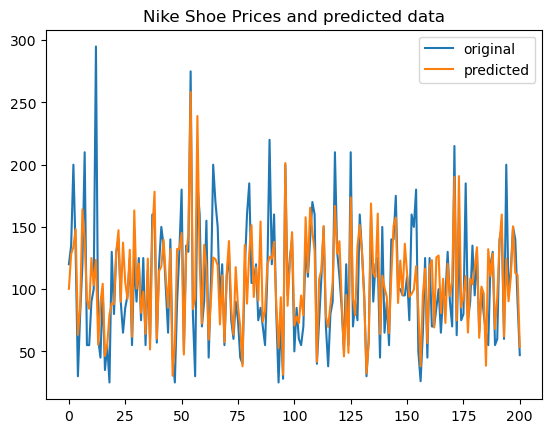

In [163]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Nike Shoe Prices and predicted data")
plt.legend()
plt.show()


In [133]:
# f_importance = model.get_booster().get_score(importance_type='gain')

# sorted_f={k: v for k, v in sorted(f_importance.items(), key=lambda item: item[1],reverse=True)}

# importance_df_sort = pd.DataFrame.from_dict(data=sorted_f, orient='index')

# ax = importance_df_sort[0:20].plot.barh()
# ax.invert_yaxis()

In [150]:
# X_train.columns

# len(model.feature_importances_)

#  model.feature_importances_[sorted_idx][-20:]

Text(0.5, 0, 'Xgboost Feature Importance')

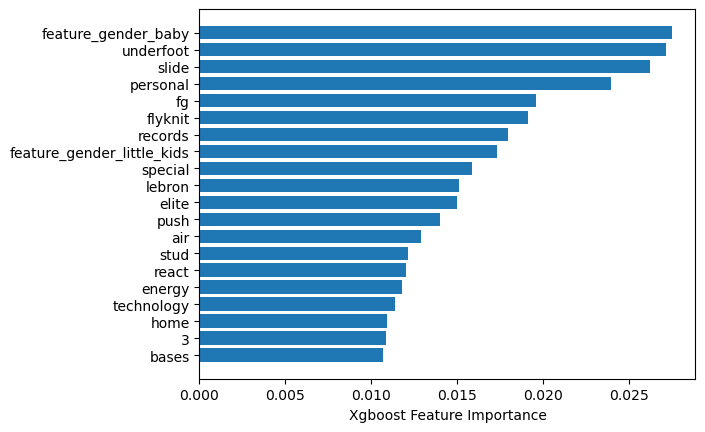

In [158]:
sorted_idx = model.feature_importances_.argsort()

plt.barh(X_train.columns[sorted_idx][-20:], model.feature_importances_[sorted_idx][-20:])
plt.xlabel("Xgboost Feature Importance")

In [ ]:
# Takes Very long

# perm_importance = permutation_importance(model, X_test, y_test)
# sorted_idx = perm_importance.importances_mean.argsort()
# plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel("Permutation Importance")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


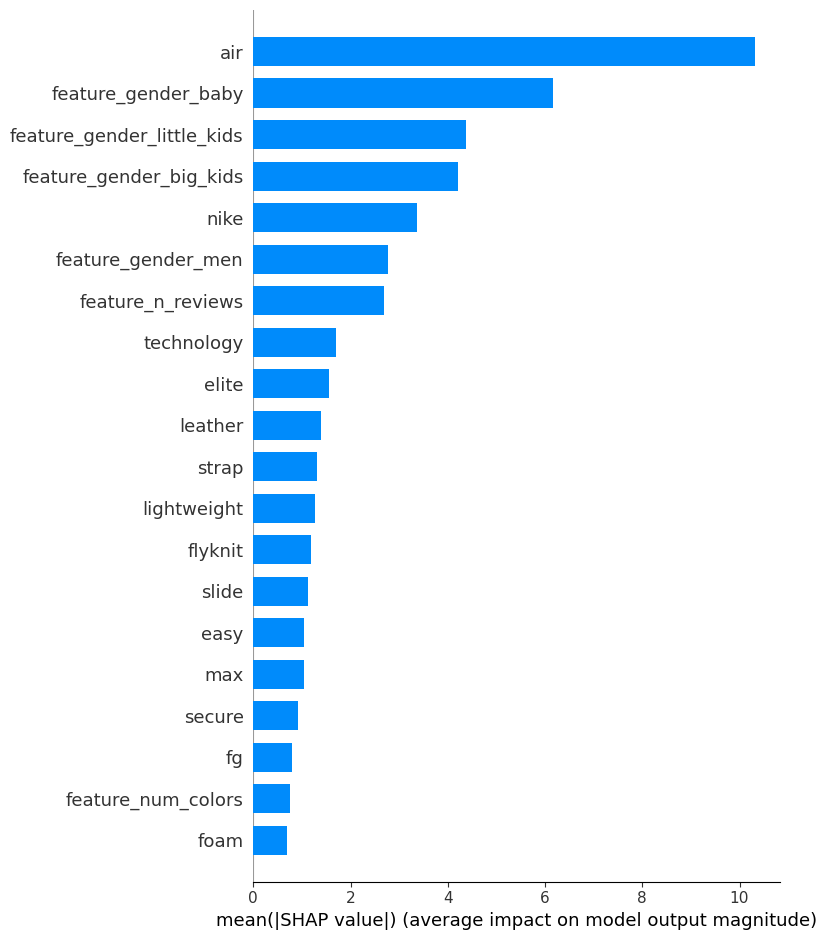

In [161]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

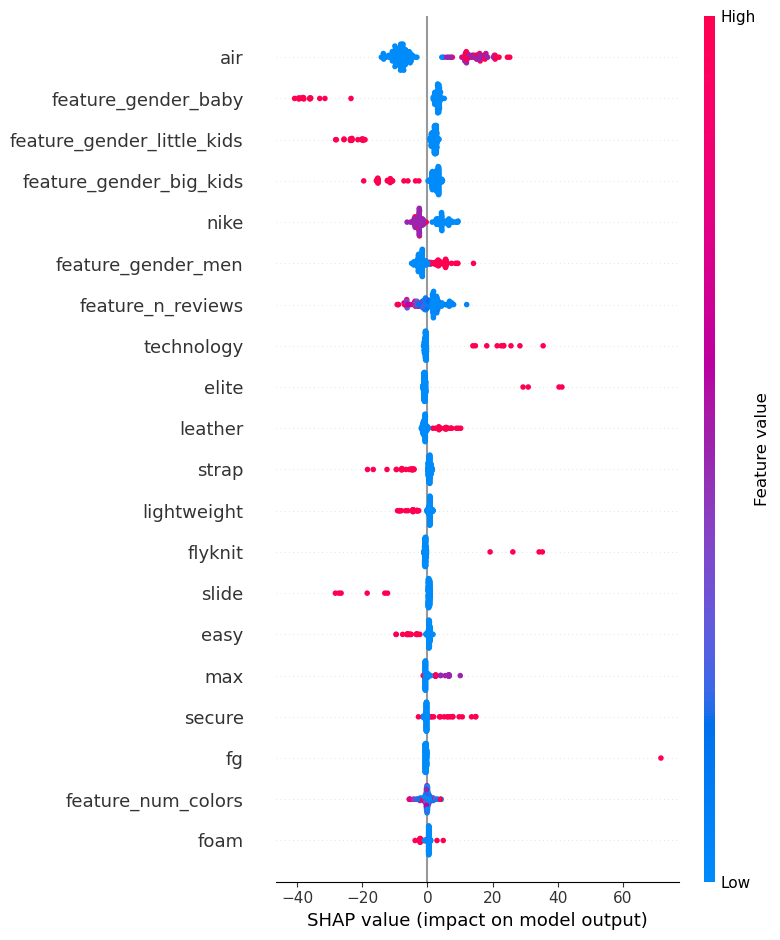

In [162]:
shap.summary_plot(shap_values, X_test)


## LGBM Regression

In [164]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnnig_rage': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1
}
 

In [165]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [166]:
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=30)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Unknown parameter: learnnig_rage
[1]	valid_0's l2: 2194.65	valid_0's l1: 37.8286
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l2: 2065.22	valid_0's l1: 36.4604
[3]	valid_0's l2: 1959.54	valid_0's l1: 35.2223
[4]	valid_0's l2: 1858.78	valid_0's l1: 34.0803
[5]	valid_0's l2: 1781.52	valid_0's l1: 33.24
[6]	valid_0's l2: 1722.38	valid_0's l1: 32.4062
[7]	valid_0's l2: 1660.55	valid_0's l1: 31.6515
[8]	valid_0's l2: 1596.81	valid_0's l1: 30.8778
[9]	valid_0's l2: 1543.22	valid_0's l1: 30.2608
[10]	valid_0's l2: 1518.98	valid_0's l1: 29.902
[11]	valid_0's l2: 1474.21	valid_0's l1: 29.2751
[12]	valid_0's l2: 1443.08	valid_0's l1: 28.8872
[13]	valid_0's l2: 1419.16	valid_0's l1: 28.5445
[14]	valid_0's l2: 1413.27	valid_0's l1: 28.4415
[15]	valid_0's l2: 1380.54	valid_0's l1: 28.0589
[16]	valid_0's l2: 1359.12	valid_0's l1: 27.7839
[17]	valid_0's l2: 1333.19	valid_0's l1: 27.4478
[18]	valid_0's l2: 1318.73	valid_0's l1: 27.319
[19]	valid_0's l

In [168]:
# prediction
y_pred = model.predict(X_test)

# accuracy check
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

MSE: 1027.64
RMSE: 32.06


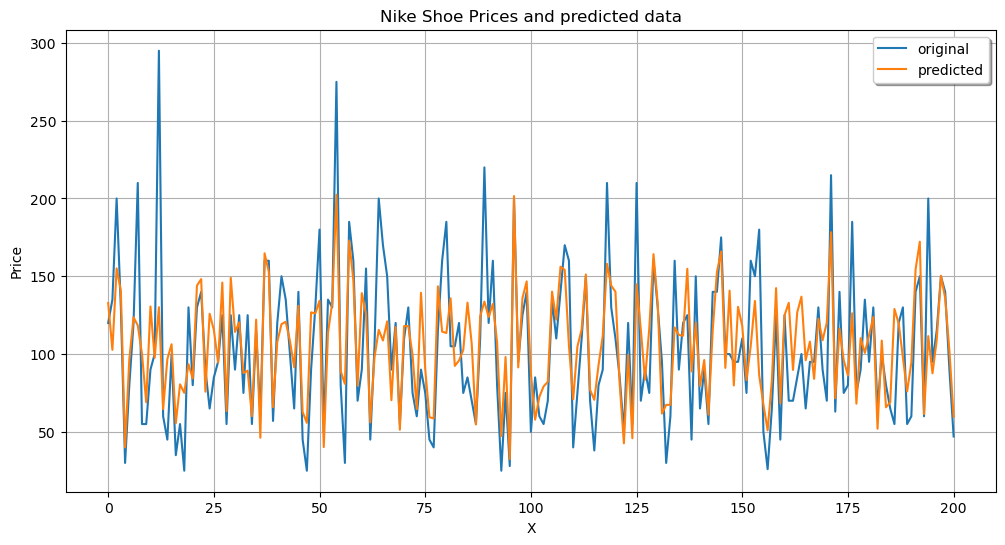

In [169]:
x_ax = range(len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Nike Shoe Prices and predicted data")
plt.xlabel('X')
plt.ylabel('Price')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

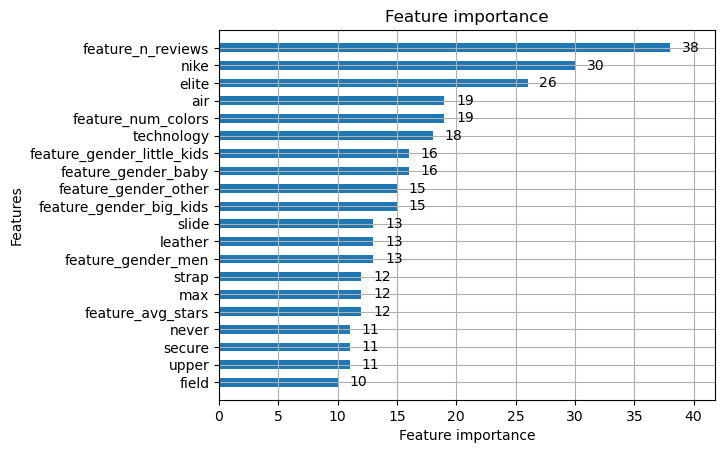

In [171]:
lgb.plot_importance(model, height=.5,max_num_features=20 )